In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load data
df = pd.read_csv('../combined_training_data_01.csv')

def calculate_mean_variance(df):
    # Calculate rolling mean and standard deviation
    window_size = 20
    df['delta3_1_mean'] = df['delta3_1'].rolling(window=window_size).mean()
    df['delta3_2_mean'] = df['delta3_2'].rolling(window=window_size).mean()
    df['delta2_1_mean'] = df['delta2_1'].rolling(window=window_size).mean()
    df['delta3_1_std'] = df['delta3_1'].rolling(window=window_size).std()
    df['delta3_2_std'] = df['delta3_2'].rolling(window=window_size).std()
    df['delta2_1_std'] = df['delta2_1'].rolling(window=window_size).std()
    df = df.dropna()

    return df

df = calculate_mean_variance(df)

# Drop the NaN values caused by rolling window
df.dropna(inplace=True)

# Preprocess data
X = df[['delta3_1', 'delta3_2', 'delta2_1', 'delta3_1_mean', 'delta3_2_mean', 'delta2_1_mean', 'delta3_1_std', 'delta3_2_std', 'delta2_1_std']]
y = df['label']

# print(activity_features)
# Encode labels: Transform categorical labels into numerical values.
label_encoder = LabelEncoder()
# Fit: extract unique classes from dataset Transform: converts the labels to numerical values.
y = label_encoder.fit_transform(y)
# print(activity_labels)

# Normalize features: Fit: calculate mean and standard deviation for each feature; Transform: scale the features to have a mean = 0 and a standard deviation = 1.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:

# Create custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, CD_features, CD_labels):
        self.features = torch.tensor(CD_features, dtype=torch.float32)
        self.labels = torch.tensor(CD_labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create data loaders
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

training_batch_size = 32
# Process the data in batches of 32 samples, Shuffle the batches to avoid overfitting (the mobel doesn't learn the order of the batches)
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=training_batch_size, shuffle=False)

# Feed Forward Neural Network inherits from torch.nn.Module, base class of all NN in PyTorch
class SimpleNN(nn.Module):
    def __init__(self, NN_input_dim, NN_hidden_dim, NN_output_dim):
        super(SimpleNN, self).__init__()
        # First linear transformation layer 
        self.fc1 = nn.Linear(NN_input_dim, NN_hidden_dim)
        # Non-linear activation function 
        self.relu = nn.ReLU()
        # Linear transformation layer. NN_output_dim is the number of classes of our classification problem.
        self.fc2 = nn.Linear(NN_hidden_dim, NN_output_dim)
    
    # Defines the forward pass of the network
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model parameters
input_dim = 9
hidden_dim = 64
output_dim = 9
# How much to change the model in response to the estimated error each time the model weights are updated.
learning_rate = 0.001

# Create instance of the NN
model = SimpleNN(input_dim, hidden_dim, output_dim)
# Loss function : measure how well the predicted class probabilities match the true labels
criterion = nn.CrossEntropyLoss()
# Optimizer to update the model’s parameters 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

'''
Training loop for the Neural Network
'''
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Calculate and print loss: how well the models predictions match the actual target values (lower = better)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Training finished')

Epoch [1/100], Loss: 0.6187
Epoch [2/100], Loss: 0.4304
Epoch [3/100], Loss: 0.4066
Epoch [4/100], Loss: 0.3923
Epoch [5/100], Loss: 0.3818
Epoch [6/100], Loss: 0.3720
Epoch [7/100], Loss: 0.3646
Epoch [8/100], Loss: 0.3582
Epoch [9/100], Loss: 0.3533
Epoch [10/100], Loss: 0.3487
Epoch [11/100], Loss: 0.3447
Epoch [12/100], Loss: 0.3412
Epoch [13/100], Loss: 0.3384
Epoch [14/100], Loss: 0.3354
Epoch [15/100], Loss: 0.3334
Epoch [16/100], Loss: 0.3301
Epoch [17/100], Loss: 0.3289
Epoch [18/100], Loss: 0.3265
Epoch [19/100], Loss: 0.3249
Epoch [20/100], Loss: 0.3232
Epoch [21/100], Loss: 0.3215
Epoch [22/100], Loss: 0.3203
Epoch [23/100], Loss: 0.3195
Epoch [24/100], Loss: 0.3177
Epoch [25/100], Loss: 0.3164
Epoch [26/100], Loss: 0.3154
Epoch [27/100], Loss: 0.3147
Epoch [28/100], Loss: 0.3135
Epoch [29/100], Loss: 0.3130
Epoch [30/100], Loss: 0.3116
Epoch [31/100], Loss: 0.3105
Epoch [32/100], Loss: 0.3093
Epoch [33/100], Loss: 0.3083
Epoch [34/100], Loss: 0.3080
Epoch [35/100], Loss: 0

#### Evaluate Model Accuracy

In [4]:
'''
Evaluate the trained NN on the test dataset to determine its accuracy.
'''
all_preds = []
all_labels = []

model.eval() # Evaluation mode
correct = 0
total = 0
with torch.no_grad(): # No gradient calculation, to save memory / compute time
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

print(f"Accuracy:{accuracy_score(all_labels, all_preds)*100:.2f}%" )
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, zero_division=0))


Accuracy:91.17%
Classification Report:
              precision    recall  f1-score   support

         lay       0.98      0.98      0.98      1291
     lay_sit       0.52      0.45      0.48       170
   lay_stand       0.65      0.51      0.57       208
         sit       0.91      0.99      0.95      2805
     sit_lay       0.88      0.66      0.75        35
   sit_stand       0.74      0.44      0.55       244
       stand       0.94      0.95      0.95      3589
   stand_lay       0.82      0.73      0.77       518
   stand_sit       0.80      0.68      0.74       295

    accuracy                           0.91      9155
   macro avg       0.81      0.71      0.75      9155
weighted avg       0.91      0.91      0.91      9155



#### Evaluate Model Accuracy and plot Confusion Matrix

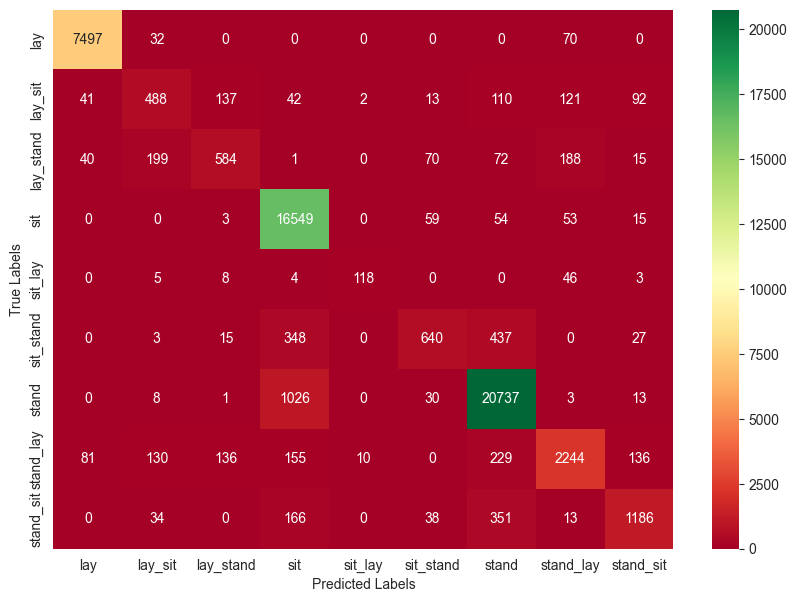

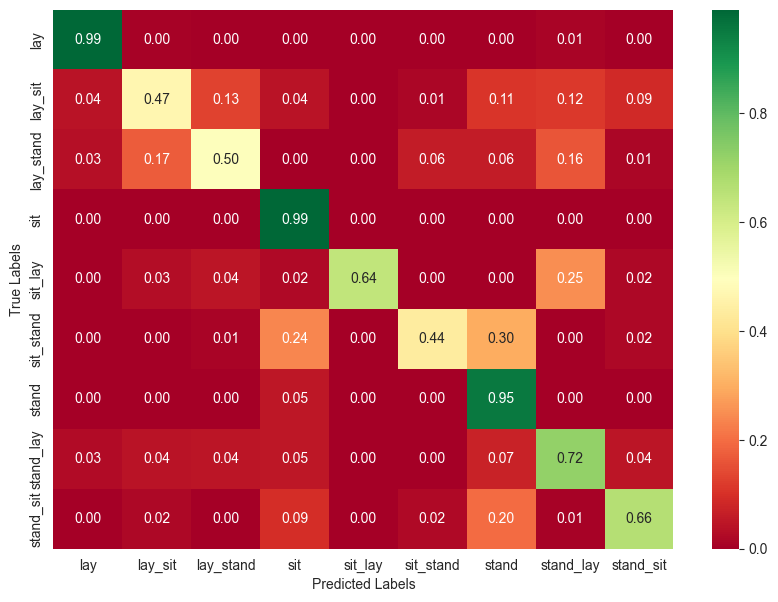

In [8]:
# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the values along rows
row_sums = cm.sum(axis=1, keepdims=True)
cm_normalized = cm.astype('float') / np.where(row_sums != 0, row_sums, 1)

# Handle zero cases
cm_normalized[np.isnan(cm_normalized)] = 0

# Plot the confusion matrix
def plot_conf_matrix(conf_matrix, fmt, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="RdYlGn", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    # plt.title(title)
    plt.show()

plot_conf_matrix(cm, 'd', 'Confusion Matrix for Random Forest with Raw Data, Mean, and Variance (Test Set)')
plot_conf_matrix(cm_normalized, ".2f", ' Normalized Confusion Matrix for Random Forest with Raw Data, Mean, and Variance (Test Set)')


#### Predict unlabeled activity using the trained NN

In [6]:
# Function to classify unlabeled data
def classify_unlabeled_data(unlabeled_data_csv):
    df_unlabeled = pd.read_csv(unlabeled_data_csv)
    df_unlabeled = calculate_mean_variance(df_unlabeled)
    features_unlabeled = df_unlabeled[['delta3_1', 'delta3_2', 'delta2_1', 'delta3_1_mean', 'delta3_2_mean', 'delta2_1_mean', 'delta3_1_std', 'delta3_2_std', 'delta2_1_std']]

    features_unlabeled = scaler.transform(features_unlabeled)
    features_unlabeled = torch.tensor(features_unlabeled, dtype=torch.float32)
    
    true_labels = df_unlabeled['label']
    true_labels_enc = label_encoder.fit_transform(true_labels)
    
    model.eval()
    with torch.no_grad():
        outputs = model(features_unlabeled)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels = label_encoder.inverse_transform(predicted.numpy())
        df_unlabeled['predicted_label'] = predicted_labels
        
        all_preds.extend(predicted.numpy())
        all_labels.extend(true_labels_enc)

        return df_unlabeled, all_preds, all_labels

# classifying unlabeled data
unlabeled_data = '../combined_training_data_01.csv'
classified_data, predicted_labels, gt_labels = classify_unlabeled_data(unlabeled_data)
classified_data.to_csv('classified_data_NN_MV.csv', index=False)


#### Confusion Matrix using the predicted data

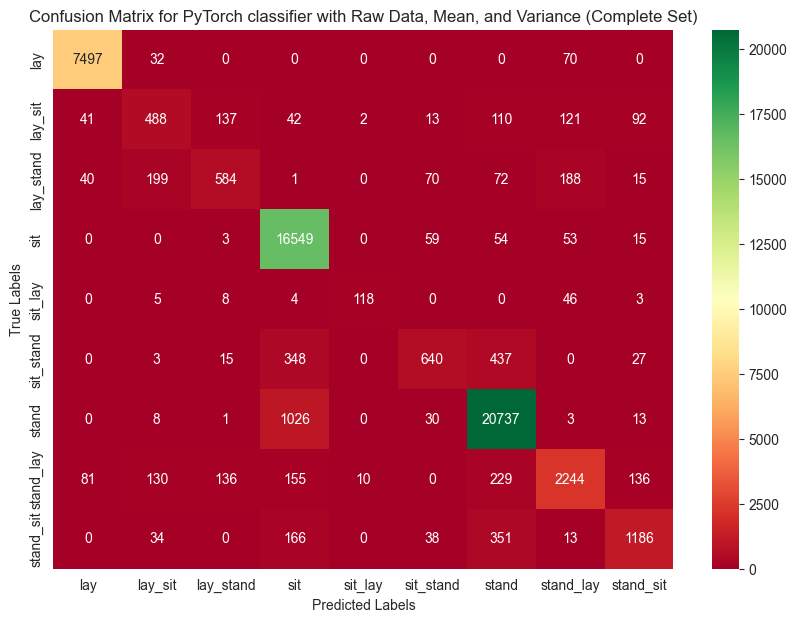

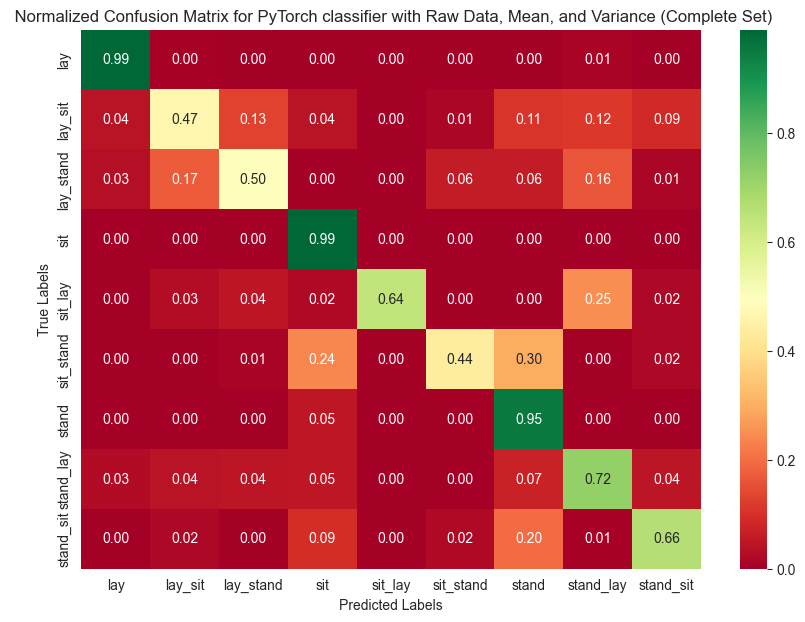

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(gt_labels, predicted_labels)

# Normalize the values along rows
row_sums = cm.sum(axis=1, keepdims=True)
cm_normalized = cm.astype('float') / np.where(row_sums != 0, row_sums, 1)

# Handle zero cases
cm_normalized[np.isnan(cm_normalized)] = 0

plot_conf_matrix(cm, 'd', 'Confusion Matrix for PyTorch classifier with Raw Data, Mean, and Variance (Complete Set)')
plot_conf_matrix(cm_normalized, ".2f", ' Normalized Confusion Matrix for PyTorch classifier with Raw Data, Mean, and Variance (Complete Set)')

